# TME 3 - Régularisation L1


In [47]:
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import functools
import operator
import itertools

%matplotlib inline

# Loading 'breast cancer' dataset, a simple dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
print("shape of X:", X.shape)
y = cancer.target
print("shape of Y:", y.shape)
print("classes in Y: ", np.unique(y))
X, y = shuffle(X, y)

# Decrease data to speed up computation
X = X[:100,:10]
y = y[:100]


shape of X: (569, 30)
shape of Y: (569,)
classes in Y:  [0 1]


In [48]:
from scipy.optimize import approx_fprime, check_grad, minimize


def decision(theta, X):
    """ The decision function that predicts a target
    :param theta: The parameter for the decision
    :param X: The data.
    
    theta.shape = (n,) and X.shape = (l, n)
    :return: a vector of predictions of shape (l,)"""
    return np.sign(X.dot(theta)) / 2 + 0.5

def loss(theta, X, y, pen):
    """ The loss function
    :param theta: The vector doing the decision
    :param X: The data
    :param y: The target values
    :param pen: The penalization parameter (The higher 'pen', the lower |theta|)
    :return: The loss for the given parameters.
    """
    mse = ((y - X.dot(theta))**2).mean()
    return mse + pen * sum([np.abs(t) for t in theta])

def gradient_loss(theta, X, y, pen):
    """ The gradient of the loss function
    :param theta: The vector doing the decision
    :param X: The data
    :param y: The target values
    :param pen: The penalization parameter
    :return: The gradient of the for the given parameters.
    """
    gradient = np.array(2 * X.T .dot(X.dot(theta) - y)) / X.shape[0] + pen * np.sign(theta)
    return gradient

### Testing if the gradient is correct ### 
print("Checking gradient with random theta:")
np.set_printoptions(precision=1, threshold=5)
for i in range(3):
    print("\n### Iteration %d ###" % i)
    theta = np.random.random(X[0].shape) - 0.5
    pen = np.random.random() / 10
    func = lambda t:loss(t, X, y, pen)
    grad = lambda t:gradient_loss(t, X, y, pen)
    print("Gradient according to approx_fprime():", approx_fprime(theta, func, epsilon=1))
    print("Gradient according to gradient_loss():", grad(theta))
    print("Error according to check_grad():", check_grad(func, grad, theta))

Checking gradient with random theta:

### Iteration 0 ###
Gradient according to approx_fprime(): [  9.0e+03   1.2e+04   6.6e+04 ...,   3.5e+01   1.0e+02   3.5e+01]
Gradient according to gradient_loss(): [  8.8e+03   1.1e+04   5.7e+04 ...,   3.5e+01   1.0e+02   3.5e+01]
Error according to check_grad(): 0.00862131459972

### Iteration 1 ###
Gradient according to approx_fprime(): [  4.1e+03   5.5e+03   3.4e+04 ...,   1.5e+01   4.8e+01   1.6e+01]
Gradient according to gradient_loss(): [  3.9e+03   5.1e+03   2.6e+04 ...,   1.5e+01   4.8e+01   1.6e+01]
Error according to check_grad(): 0.00741776115067

### Iteration 2 ###
Gradient according to approx_fprime(): [ -6.3e+03  -8.0e+03  -3.4e+04 ...,  -2.6e+01  -7.8e+01  -2.6e+01]
Gradient according to gradient_loss(): [ -6.5e+03  -8.4e+03  -4.3e+04 ...,  -2.6e+01  -7.8e+01  -2.6e+01]
Error according to check_grad(): 0.00668089901069


###########  Step 0 : #################
========= i = 0, random idx = 96 ===========
debug: check_grad: 0.00417990429543
Gradient:      [  7.78e+03   1.11e+04   5.07e+04 ...,   3.34e+01   1.21e+02   3.88e+01]
Theta before:  [ 0.89  0.88  0.93 ...,  0.51  0.23  0.17]
Theta after:   [ 0.    0.    0.   ...,  0.48  0.11  0.14]
========= i = 1, random idx = 94 ===========
debug: check_grad: 0.00830325373478
Gradient:      [ -2.42e+01  -3.09e+01  -1.57e+02 ...,  -7.71e-02  -3.03e-01  -9.38e-02]
Theta before:  [ 0.    0.    0.   ...,  0.48  0.11  0.14]
Theta after:   [ 0.02  0.03  0.16 ...,  0.48  0.11  0.14]
========= i = 2, random idx = 86 ===========
debug: check_grad: 0.015758014426
Gradient:      [  1.31e+04   2.35e+04   8.46e+04 ...,   2.99e+01   1.64e+02   7.16e+01]
Theta before:  [ 0.02  0.03  0.16 ...,  0.48  0.11  0.14]
Theta after:   [ 0.    0.    0.   ...,  0.45  0.    0.06]
========= i = 3, random idx = 27 ===========
debug: check_grad: 0.00389586608039
Gradient:      [ -2.05e+01

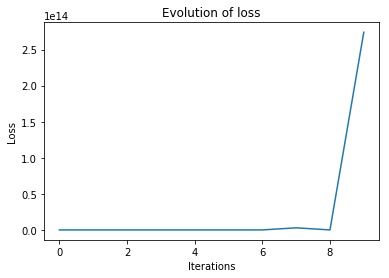

In [57]:
def gradient_l1(theta, X, y, max_iter=100, step=1e-1, pen=0.1, verbose=0, plot=False):
    """ Performs gradient descent to find the best theta
    :param theta: The initial scalar for the search
    :param X: The data
    :param y: The target values
    :param max_iter: The number of iterations
    :param step: The scalar the will be multiplied to the gradient vector to increment theta
    :param pen: The regularization parameter
    :param verbose: The level of displayed information
    :param plot: Whether to plot the evolution of the loss
    
    :return: The theta at the end of the gradient descent"""
    
    (l, n) = X.shape
    losses = []
    for it in range(max_iter):
        if verbose >= 1:
            print("###########  Step", it, ": #################")
        for i in range(l):
            # Sample a random point 
            idx = np.random.randint(0, l)
            if verbose >= 2:
                print("========= i = %d, random idx = %d ===========" % (i, idx))
            # Compute the gradient on this single random point:
            local_loss = lambda t: loss(t, np.array([X[idx]]), np.array([y[idx]]), pen)
            grad = approx_fprime(theta, local_loss, epsilon=step)
            
            grad = gradient_loss(theta, np.array([X[idx]]), np.array([y[idx]]), pen)
            
            #debug
            if verbose >=2:
                local_grad = lambda t: gradient_loss(theta, np.array([X[idx]]), np.array([y[idx]]), pen)
                print("debug: check_grad:", check_grad(local_loss, local_grad, theta))
                
            if verbose >= 2:
                print("Gradient:     ",grad)
                print("Theta before: ", theta)
                
            theta_prime = theta - step * grad
            theta_prime[theta * theta_prime < 0] = 0
            theta = theta_prime
            
            if verbose >= 2:
                print("Theta after:  ", theta)
                
        general_loss = loss(theta, X, y, pen)
        losses.append(general_loss)
        if verbose >= 1:
            print("Loss = %f" % (general_loss))
    
    if plot:
        plt.plot(losses)
        plt.title("Evolution of loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        
    return theta

# Optimization parameters
theta_init = np.random.random(X[0].shape)
max_iter = 10
step     = 1e-3
pen      = 1e-3

# Find theta 
np.set_printoptions(precision=2, threshold=5)
theta = gradient_l1(theta_init, X, y, max_iter=max_iter, pen=pen, step=step, verbose=2, plot=True)
theta_minimize = minimize(lambda t:loss(t, X, y, pen), theta_init).x
print("theta with gradient_l1():", theta)
print("theta with minimize()   :", theta_minimize)


# print("Finding the best theta, step and pen parameters:")
# params = {"step": np.logspace(-6, 1, 10),
#           "pen" : np.logspace(-6, 1, 10)}
# combinations = functools.reduce(operator.mul, [len(elt) for elt in params.values()])
# best_params = {"step": params["step"][0],  "pen": params["pen"][0]}
# best_theta = gradient_l1(theta_init, X, y, max_iter=max_iter, step=best_params["step"], pen=best_params["pen"])
# print("Searching best parameters")
# for i, (it_step, it_pen) in enumerate(itertools.product(params["step"], params["pen"])):
#     theta = gradient_l1(theta_init, X, y, max_iter=max_iter, step=it_step, pen=it_pen)
#     print("%d/%d" % (i, combinations) )
#     if loss(theta, X, y, it_pen) < loss(best_theta, X, y, it_pen):
#     #np.linalg.norm(theta - theta_minimize) < np.linalg.norm(best_theta - theta_minimize):
#         best_theta = theta
#         best_params = {"step": it_step, "pen": it_pen}
        



In [13]:
print("Done")
print(best_params)
print(best_theta)
print(loss(best_theta, X, y, pen))

Done
{'pen': 10.0, 'step': 9.9999999999999995e-07}
[ 0.    0.    0.01 -0.    0.66  0.    0.2   0.53  0.61  0.58]
0.243684097085


In [8]:
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """ Custom linear classifier """
    
    def __init__(self, max_iter=1000, step=1e-2, pen=1e-2, verbose=0):
        self.theta= 0
        self.max_iter = max_iter
        self.step = step
        self.pen = pen
        self.verbose = verbose
    
    def fit(self, X, y):
        self.theta = gradient_l1(np.ones_like(X[0]), X, y, 
                                 max_iter=self.max_iter, 
                                 step=self.step, 
                                 pen=self.pen,
                                 verbose=self.verbose)
        
    def predict(self, X):
        return decision(theta, X)

    def get_theta(self):
        return self.theta

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold



kf = KFold(n_splits=4)


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    clf = LinearClassifier(max_iter=20, step=step, pen=pen, verbose=2)
    clf.fit(X_train, Y_train)
    print("Theta found:", clf.get_theta())
    pred = clf.predict(X_test)
    
    print("KFold:")
    print("Y_Pred: ", pred)
    print("Y_reel: ", Y_test)
    print("Score: ", accuracy_score(pred, Y_test))
    print("Errors: ", Y_test[pred != Y_test])


###########  Step 0 : #################
========= i = 0, idx = 63 ===========
Gradient:      [  2.62e+04   3.28e+04   1.72e+05   1.44e+06   1.57e+02   1.99e+02
   2.00e+02   1.12e+02   2.91e+02   1.00e+02]
Theta before:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Theta after:   [ 0.    0.    0.    0.    0.84  0.8   0.8   0.89  0.71  0.9 ]
========= i = 1, idx = 67 ===========
Gradient:      [ -8.44e-01  -3.02e+00  -3.40e+00   1.45e+02  -1.84e-02   2.28e-02
   5.77e-02   3.00e-02  -3.70e-02  -1.53e-02]
Theta before:  [ 0.    0.    0.    0.    0.84  0.8   0.8   0.89  0.71  0.9 ]
Theta after:   [  8.44e-04   3.02e-03   3.40e-03  -1.45e-01   8.43e-01   8.01e-01
   8.00e-01   8.88e-01   7.09e-01   9.00e-01]
========= i = 2, idx = 55 ===========
Gradient:      [ -3.23e+03  -4.01e+03  -2.13e+04  -1.80e+05  -1.91e+01  -2.45e+01
  -2.50e+01  -1.40e+01  -3.55e+01  -1.22e+01]
Theta before:  [  8.44e-04   3.02e-03   3.40e-03  -1.45e-01   8.43e-01   8.01e-01
   8.00e-01   8.88e-01   7.09e-01   9.00e

/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: overflow encountered in multiply
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in square
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in multiply
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in multiply
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in less
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in subtract
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in absolute


Theta after:   [  0.00e+000   0.00e+000   0.00e+000  -3.65e+282   0.00e+000   0.00e+000
   0.00e+000   0.00e+000   0.00e+000   0.00e+000]
========= i = 57, idx = 28 ===========
Gradient:      [ -8.16e+286  -1.01e+287  -5.37e+287  -4.54e+288  -4.83e+284  -6.18e+284
  -6.32e+284  -3.53e+284  -8.97e+284  -3.08e+284]
Theta before:  [  0.00e+000   0.00e+000   0.00e+000  -3.65e+282   0.00e+000   0.00e+000
   0.00e+000   0.00e+000   0.00e+000   0.00e+000]
Theta after:   [  8.16e+283   1.01e+284   5.37e+284   0.00e+000   4.83e+281   6.18e+281
   6.32e+281   3.53e+281   8.97e+281   3.08e+281]
========= i = 58, idx = 39 ===========
Gradient:      [  1.63e+288   2.12e+288   1.07e+289   8.36e+289   1.03e+286   1.23e+286
   1.15e+286   6.43e+285   1.92e+286   6.66e+285]
Theta before:  [  8.16e+283   1.01e+284   5.37e+284   0.00e+000   4.83e+281   6.18e+281
   6.32e+281   3.53e+281   8.97e+281   3.08e+281]
Theta after:   [  0.00e+000   0.00e+000   0.00e+000  -8.36e+286   0.00e+000   0.00e+000
   0.0